# Evaluation of Reconstruction in 2D

## Imports

In [4]:
import matplotlib.pyplot as plt
import os
import glob
from scipy.spatial.transform import Rotation as R

from Utils import *

np.random.seed(42)
torch.manual_seed(42)

## Definitions

In [1]:
MRC = ".mrc"
RAW = ".raw"
TIF = ".tif"

gt_path = "./Tomograms/Synthetic/GT/"
gt_format = RAW

model_path = "./Tomograms/Synthetic/L2Clean/"
model_format = RAW

save_to = "./Results/Evaluation2D/"

resolution = 512
voxel_type_gt = 'uint8' #'uint16'
voxel_type_model = 'uint8' #'uint16'


num_projections = 20

In [2]:
print("Volume Path: "+str(gt_path))
os.makedirs(save_to, exist_ok=True)

Volume Path: C:\Users\Hannah\Documents\ABEM\_SW\CVPR_GIT_new\Reconstruction_Data\_Data\Synthetic\PhantomVolume/


In [5]:
proj_angles = np.zeros((num_projections,3))
proj_angles = np.random.randint(0,360,(num_projections,2)) 

## Load GT and Implict Model

In [6]:
if(gt_format == MRC):
    volume_gt = open_mrc(gt_path)
elif(gt_format == TIF):
    volume_gt = open_tif_stack(gt_path)
else: 
    volume_gt = open_raw(gt_path, voxel_type_gt)
volume_gt = min_max(volume_gt)
print("GT init shape: "+str(volume_gt.shape))

w,h,_ = volume_gt.shape

Max loaded data: 255
GT init shape: (1000, 1000, 1000)


In [11]:
if(model_format == MRC):
    volume_model = open_mrc(model_path)
elif(model_format == TIF):
    volume_model = open_tif_stack(model_path)
else: 
    volume_model = open_raw(model_path, voxel_type_model)
volume_model = min_max(volume_model)
print("Tomogram init shape: "+str(volume_model.shape))



Max loaded data: 255
Tomogram init shape: (1000, 1000, 1000)


## Function Definitions

In [12]:
def init_view():
    center_distance = np.sqrt(2)*w
    init_img = np.zeros((w,h,3))
    x_coords = np.linspace(start = -1, stop = 1, num =  w) * w
    y_coords = np.linspace(start = -1, stop = 1, num =  w) * w

    x_coords, y_coords = np.meshgrid(x_coords,y_coords)
    init_img[:,:,0] = x_coords.T
    init_img[:,:,1] = y_coords.T
    init_img[:,:,2] = center_distance
    return init_img

def get_dir_origin(init_proj, angle):
    proj = init_proj.reshape(-1,3)
    dir = np.array([0,0,-1])
    x_rot = R.from_euler('x', angle[0], degrees=True)
    proj = x_rot.apply(proj)
    dir = x_rot.apply(dir)

    y_rot = R.from_euler('y', angle[1], degrees=True)
    proj = y_rot.apply(proj)
    dir = y_rot.apply(dir)

    proj = proj.reshape(w,h,3)
    return proj, (dir/(np.linalg.norm(dir)))

def scale_to_vol(pos):
        return (pos+w)/2

def projections(volume, model):
        samples = 1024 
        r_length = (np.sqrt(2))
        r_length = r_length*w
        step_size = r_length/ samples

        init_img = init_view()

        psnr_vals = []
        mse_vals = []
        dssim_vals = []
        for j in range(num_projections):
            proj, dir = get_dir_origin(init_img, proj_angles[j,:])
            projection_volume = np.zeros((w,h))
            projection_model = np.zeros((w,h))

            #volume
            proj_volume = scale_to_vol(proj)
            for i in tqdm(range(samples)):
                sample = i*dir*step_size + proj_volume
                s = sample.astype(int)
                bool_arr = (s >= volume.shape[0]) | (s < 0)
                bool_arr = np.sum(bool_arr, axis = -1)
                cliped_s = np.clip(s, 0, volume.shape[0]-1)
                densities = volume[cliped_s[:,:,1], cliped_s[:,:,0], cliped_s[:,:,2]]
                projection_volume += np.where(bool_arr, 0, densities)*(step_size/100)

                densities = model[cliped_s[:,:,1], cliped_s[:,:,0], cliped_s[:,:,2]]
                projection_model += np.where(bool_arr, 0, densities)*(step_size/100)

            projection_volume = min_max(np.exp(-projection_volume))
            projection_model = min_max(np.exp(-projection_model))

            save_tif(save_to+"/Projection_"+str(j)+".tif", projection_model)
            save_tif(save_to+"/GT_"+str(j)+".tif", projection_volume)

            
            fig, axs = plt.subplots(1,2)
            axs[0].imshow(projection_model)
            axs[0].set_title("Projection from Model")
            axs[1].imshow(projection_volume)
            axs[1].set_title("Projection from GT")
            plt.show()
            

            psnr_vals.append(psnr(projection_volume, projection_model)[0])
            mse_vals.append(mse(projection_volume, projection_model)[0])
            dssim_vals.append(dssim(projection_volume, projection_model)[0])

        return psnr_vals, mse_vals, dssim_vals

## Compute and Evaluate Projections

100%|██████████| 1024/1024 [01:58<00:00,  8.64it/s]


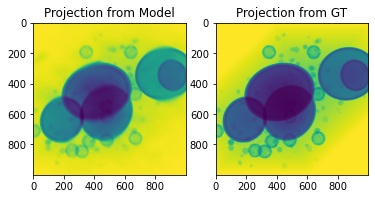

c:\Users\Hannah\Documents\ABEM\_SW\CVPR_GIT\Implicit-Electron-Tomography\Utils.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  mssim = m.structural_similarity(vol_gt, vol, multichannel=False)
100%|██████████| 1024/1024 [02:17<00:00,  7.45it/s]


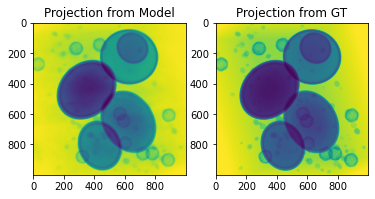

100%|██████████| 1024/1024 [02:28<00:00,  6.91it/s]


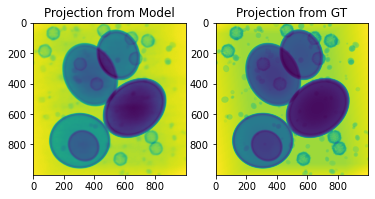

100%|██████████| 1024/1024 [01:28<00:00, 11.61it/s]


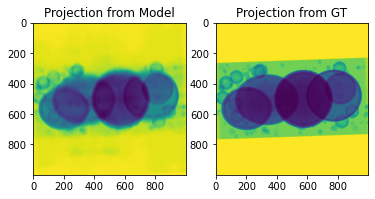

100%|██████████| 1024/1024 [02:14<00:00,  7.61it/s]


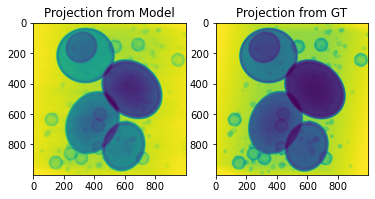

100%|██████████| 1024/1024 [01:39<00:00, 10.26it/s]


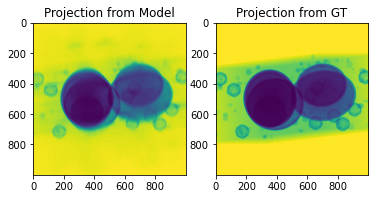

100%|██████████| 1024/1024 [02:12<00:00,  7.73it/s]


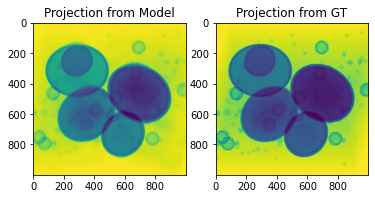

100%|██████████| 1024/1024 [01:33<00:00, 11.01it/s]


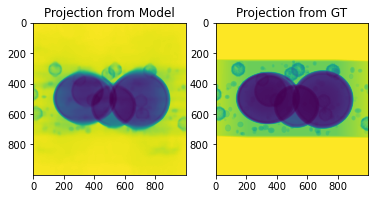

100%|██████████| 1024/1024 [01:42<00:00, 10.01it/s]


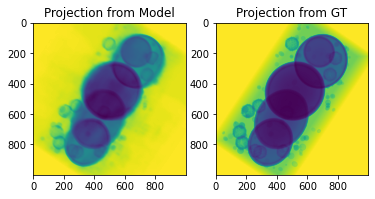

100%|██████████| 1024/1024 [01:52<00:00,  9.12it/s]


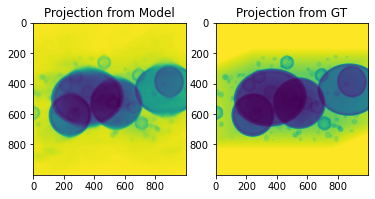

100%|██████████| 1024/1024 [02:13<00:00,  7.65it/s]


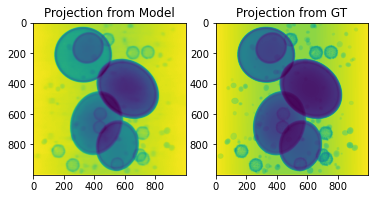

100%|██████████| 1024/1024 [02:05<00:00,  8.14it/s]


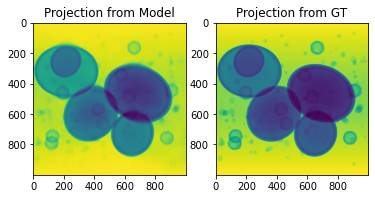

100%|██████████| 1024/1024 [01:34<00:00, 10.85it/s]


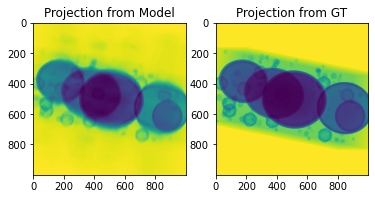

100%|██████████| 1024/1024 [02:18<00:00,  7.37it/s]


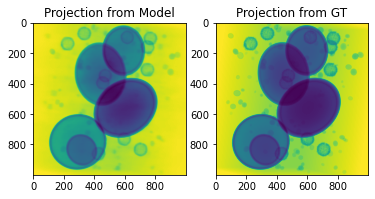

100%|██████████| 1024/1024 [02:07<00:00,  8.04it/s]


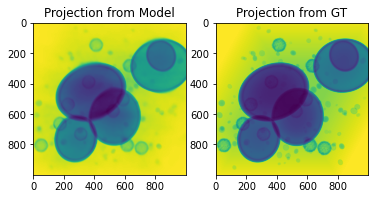

100%|██████████| 1024/1024 [02:29<00:00,  6.86it/s]


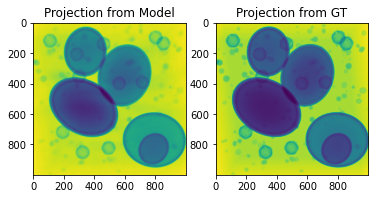

100%|██████████| 1024/1024 [01:32<00:00, 11.12it/s]


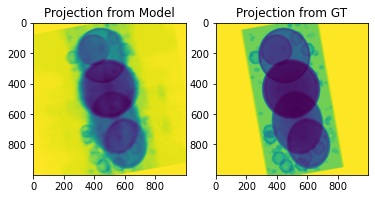

100%|██████████| 1024/1024 [01:27<00:00, 11.76it/s]


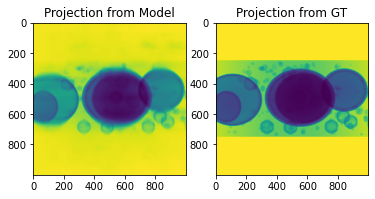

100%|██████████| 1024/1024 [01:57<00:00,  8.69it/s]


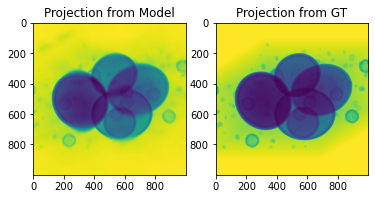

100%|██████████| 1024/1024 [01:58<00:00,  8.63it/s]


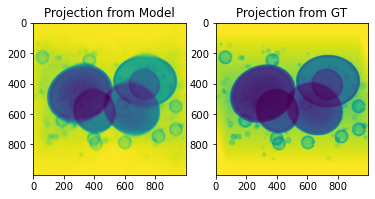

In [13]:
psnr_vals, mse_vals, dssim_vals = projections(volume_gt, volume_model)

In [14]:
eval_str = "PSNR: "+str(np.mean(psnr_vals))+" | MSE: "+str(np.mean(mse_vals))+" | DSSIM: "+str(np.mean(dssim_vals))
print(eval_str)

save_txt(eval_str, save_to+"/results.txt")

PSNR: 21.058520835161012 | MSE: 0.007898237148756555 | DSSIM: 0.03401555083348244
Saved text file to: ./Results/Evaluation2D/results.txt
